In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

Matplotlib created a temporary cache directory at /tmp/matplotlib-yn47yv3m because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_TFC1_4000_patch_head.npy'
# data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_TFC1_4000_batch_size_100_patch_head.npy'

data = np.load(data_path)
queries = np.load(data_path.replace("patch_head", "queries"))
documents = np.load(data_path.replace("patch_head", "documents"))

queries = queries.reshape(-1, queries.shape[-1])
documents = documents.reshape(-1, documents.shape[-1])

/scratch_local/esx208-1051587/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's try to sort all patching effects by the magnitude

In [3]:
mean_magnitude = np.mean(np.abs(data), axis=(-2,-1))
sorted_magnitudes = np.argsort(mean_magnitude)[::-1]
sorted_data = data[sorted_magnitudes]

<Axes: >

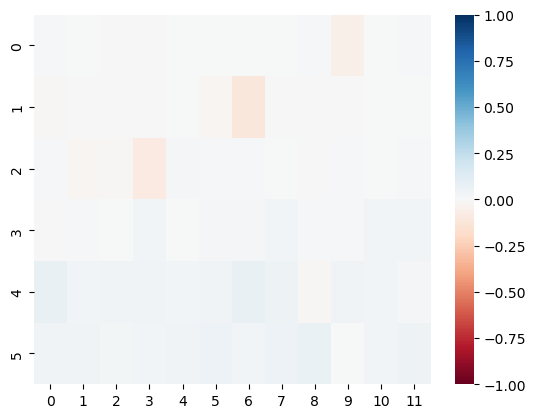

In [4]:
sns.heatmap(
        np.mean(data, axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

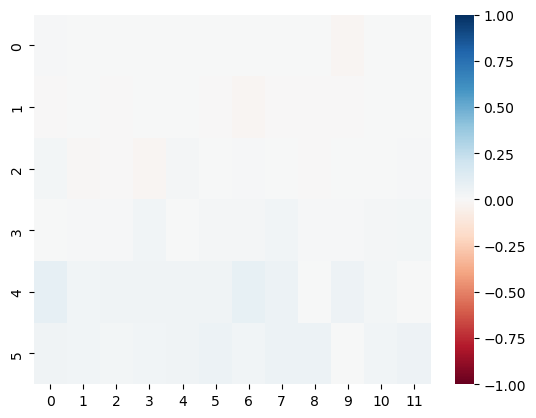

In [5]:
sns.heatmap(
        np.mean(sorted_data[1000:], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

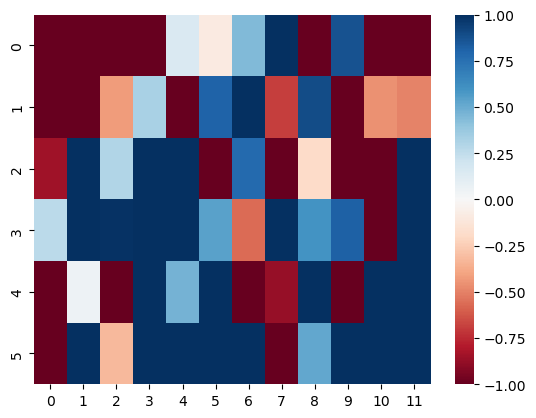

In [6]:
sns.heatmap(
        sorted_data[0],
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

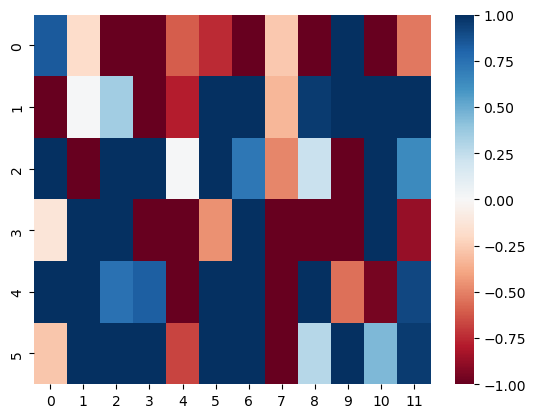

In [7]:
sns.heatmap(
        sorted_data[1],
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

<Axes: >

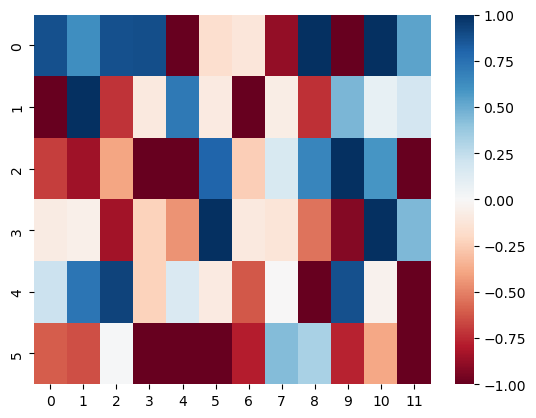

In [8]:
sns.heatmap(
        sorted_data[2],
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

In [9]:
sorted_data[2]

array([[ 8.76229227e-01,  6.20549321e-01,  8.80637527e-01,
         8.89708400e-01, -1.04340458e+00, -1.64716855e-01,
        -1.21397085e-01, -8.80552709e-01,  1.51661575e+00,
        -5.09282827e+00,  1.99660897e+00,  5.32468617e-01],
       [-1.23965752e+00,  2.93981004e+00, -7.19226837e-01,
        -9.52017605e-02,  7.15072930e-01, -8.85893553e-02,
        -1.71671753e+01, -7.50254318e-02, -7.27534771e-01,
         4.59393024e-01,  8.12987462e-02,  1.85571387e-01],
       [-6.92692459e-01, -8.46982002e-01, -3.91658187e-01,
        -1.39052219e+01, -1.08858931e+00,  7.99254000e-01,
        -2.48050183e-01,  1.58358768e-01,  6.61495447e-01,
         1.28357065e+00,  5.90200067e-01, -2.19879627e+00],
       [-8.22312683e-02, -6.11224137e-02, -8.39945734e-01,
        -2.27365211e-01, -4.49813485e-01,  1.20549333e+00,
        -9.68124792e-02, -1.25042394e-01, -5.43404520e-01,
        -9.14292991e-01,  1.47329605e+00,  4.47015941e-01],
       [ 2.15835869e-01,  7.31603920e-01,  9.2633098

Let's try to extract some features from the dataset and test whether there will be a correlation between these features and the patching effect

In [6]:
def load_data(data_path):
    data = np.load(data_path)
    queries = np.load(data_path.replace("patch_head", "queries"))
    documents = np.load(data_path.replace("patch_head", "documents"))
    
    if len(queries.shape) == 3:
        queries = queries.reshape(-1, queries.shape[-1])
        documents = documents.reshape(-1, documents.shape[-1])
    
    return data, queries, documents

data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_TFC1_4000_batch_size_100_patch_head.npy'
data, queries, documents = load_data(data_path)

In [7]:
data[0]

array([[ 2.70723854e-03,  4.69205342e-03,  2.48297793e-03,
         5.58038615e-03,  3.06257163e-03,  4.19345452e-04,
         3.16969422e-03, -5.11575351e-03,  3.77977011e-03,
         6.53186089e-06,  5.35830297e-03,  1.69654191e-03],
       [ 9.28917713e-03,  9.85962618e-03, -1.52105268e-03,
        -1.41784921e-03,  2.77691172e-03, -2.85660033e-04,
        -4.13684502e-05,  6.00495725e-04, -2.68546562e-03,
         8.46616272e-03,  2.76210625e-03, -1.02550210e-03],
       [ 5.77372918e-03, -3.53722018e-03, -2.88882433e-03,
         3.72316048e-04,  2.20341445e-03,  3.88384424e-03,
        -1.68522005e-03,  3.05516901e-03,  2.08061538e-03,
        -3.14617949e-03,  6.69254456e-03,  2.18556053e-03],
       [ 4.39289398e-03,  9.48861649e-04,  8.12955387e-03,
         4.65517007e-02,  4.40247415e-04,  1.34878568e-02,
         7.04003964e-03,  8.35372731e-02,  2.04621418e-03,
         5.48676289e-05,  2.36035325e-02,  7.54830539e-02],
       [ 8.02012309e-02,  7.10831881e-02,  6.0886956

In [28]:
def plot_dependence(data, feature_x, feature_y='avg_patch_effect', ylim=[0,1]):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[feature_x], y=data[feature_y])
    plt.ylim(ylim)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f'Dependence between {feature_x} and {feature_y}')
    plt.show()
    
def plot_dependence_no_limit(data, feature_x, feature_y='avg_patch_effect'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data[feature_x], y=data[feature_y])
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f'Dependence between {feature_x} and {feature_y}')
    plt.show()

In [9]:
FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
in_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

all_data_pd = pd.read_csv(in_file, sep='\t')
# processed_frame = process_frame(all_data)
# dataset = MechDataset(processed_frame, pre_perturbed=True)

In [32]:
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.split(' ')[-1])
all_data_pd['avg_patch_effect'] = np.mean(np.abs(data), axis=(-2,-1))
all_data_pd['avg_patch_effect_selected_heads'] = np.mean(np.abs(data)[:, [0,1,2], [9,6,3]], axis=-1)
all_data_pd['max_patch_effect'] = np.max(np.abs(data), axis=(-2,-1))
all_data_pd['tokenized_query_length'] = all_data_pd['query'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['tokenized_doc_length'] = all_data_pd['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['injected_term_exists'] = all_data_pd.apply(lambda row: row['perturbed_text'].split(' ')[-1] in row['text'].lower(), axis=1)

In [33]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,injected_term,avg_patch_effect,avg_patch_effect_selected_heads,tokenized_query_length,tokenized_doc_length,injected_term_exists,max_patch_effect
0,768208,what is mamey,3186011,This species has an elongated oblong narrow sh...,0,True,100.17598,15,82.417660,17.758316,This species has an elongated oblong narrow sh...,mamey,0.018329,0.000140,7,49,False,0.177763
1,768208,what is mamey,6835292,Their size and excellent color retention prope...,0,True,96.84707,43,79.320170,17.526901,Their size and excellent color retention prope...,mamey,0.016577,0.002437,7,66,False,0.156851
2,768208,what is mamey,8041502,‘I have a friend who is selling a product that...,0,True,95.64876,53,78.457390,17.191368,‘I have a friend who is selling a product that...,mamey,0.017408,0.006367,7,57,False,0.156779
3,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,99.95468,4,82.975464,16.979218,": to add moisture to (something, such as a per...",theraderm,0.022695,0.004866,9,18,False,0.203131
4,121171,define etruscans,7409541,"Fully accessible PDF installation guide, and a...",0,True,92.53462,453,76.296555,16.238068,"Fully accessible PDF installation guide, and a...",etruscans,0.015925,0.004330,6,63,False,0.118651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,451602,medicare's definition of mechanical ventilation,6286982,Mechanical ventilation is indicated when the p...,3,True,100.88232,43,100.808110,0.074203,Mechanical ventilation is indicated when the p...,ventilation,0.144056,0.404731,9,95,True,1.018222
3996,1136962,why did the ancient egyptians call their land ...,596001,The ancient Egyptian name as transliterated fr...,3,True,105.90979,10,105.836235,0.073555,The ancient Egyptian name as transliterated fr...,call,0.047811,0.057352,17,101,True,0.196007
3997,258062,how long does it take to remove wisdom tooth,4174313,The time it takes to remove the tooth will var...,3,True,109.91658,36,109.843506,0.073074,The time it takes to remove the tooth will var...,wisdom,0.066708,0.294887,11,144,True,0.484148
3998,583468,what carvedilol used for,7491704,what carvedilol is and what it is used for car...,3,True,106.24535,47,106.174270,0.071083,what carvedilol is and what it is used for car...,carvedilol,0.161247,0.526062,8,112,True,0.690491


Corellation between score delta and patching effect

In [34]:
target_property = 'score_delta'

In [35]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

-0.16698845180916094

In [36]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

-0.14471586109339435

In [37]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

-0.8381938941336351

In [38]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

-0.7304182675799322

In [40]:
all_data_pd[target_property].corr(all_data_pd['max_patch_effect'], method='pearson')

-0.1190742807266431

In [39]:
all_data_pd[target_property].corr(all_data_pd['max_patch_effect'], method='spearman')

-0.5562831478933108

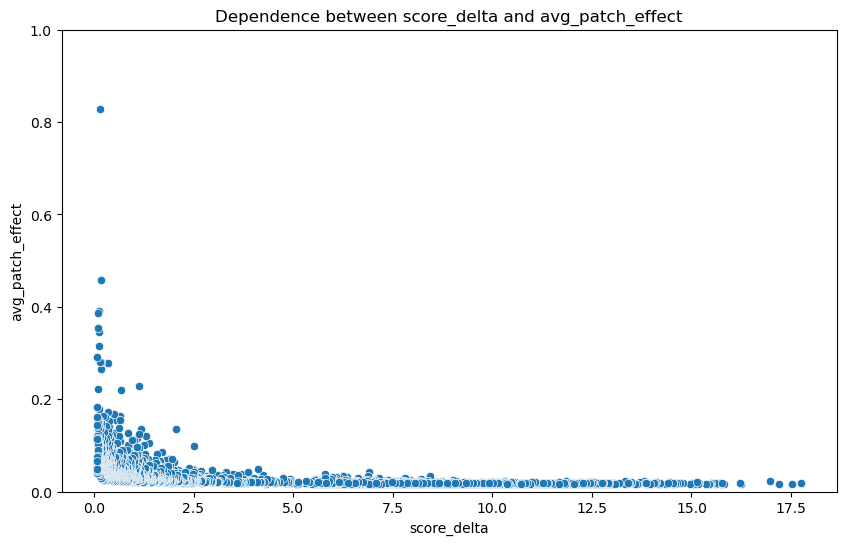

In [45]:
plot_dependence(all_data_pd, 'score_delta', 'avg_patch_effect')

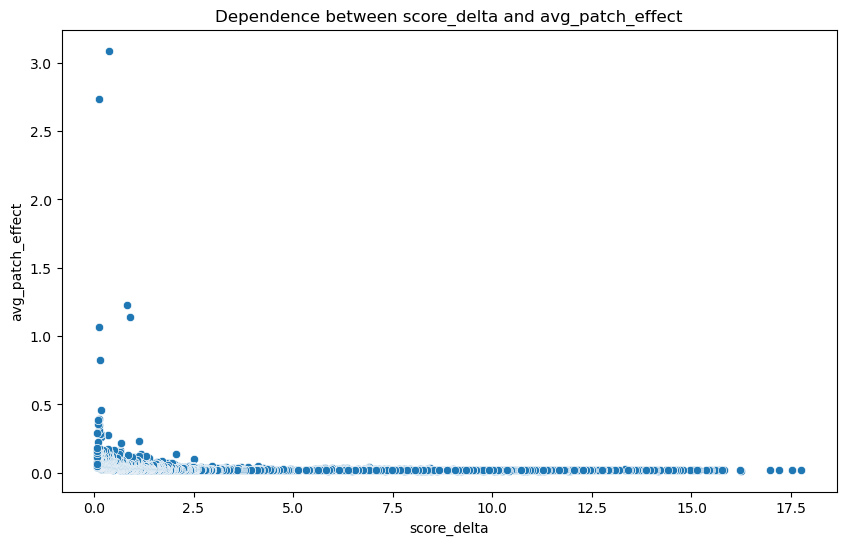

In [46]:
plot_dependence_no_limit(all_data_pd, 'score_delta', 'avg_patch_effect')

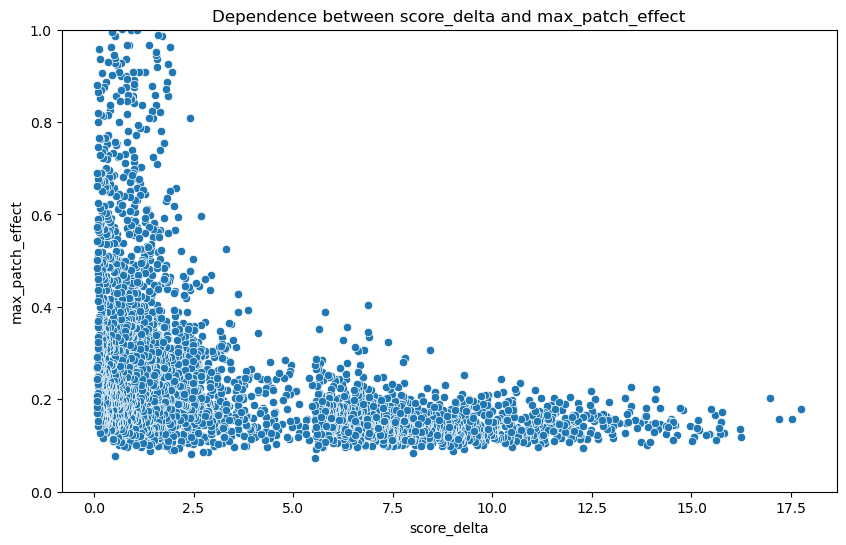

In [41]:
plot_dependence(all_data_pd, 'score_delta', 'max_patch_effect')

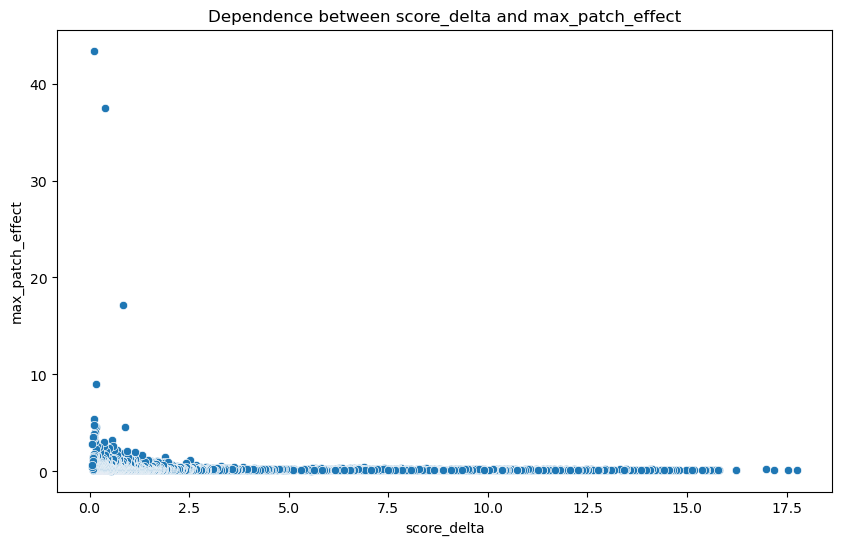

In [43]:
plot_dependence_no_limit(all_data_pd, 'score_delta', 'max_patch_effect')

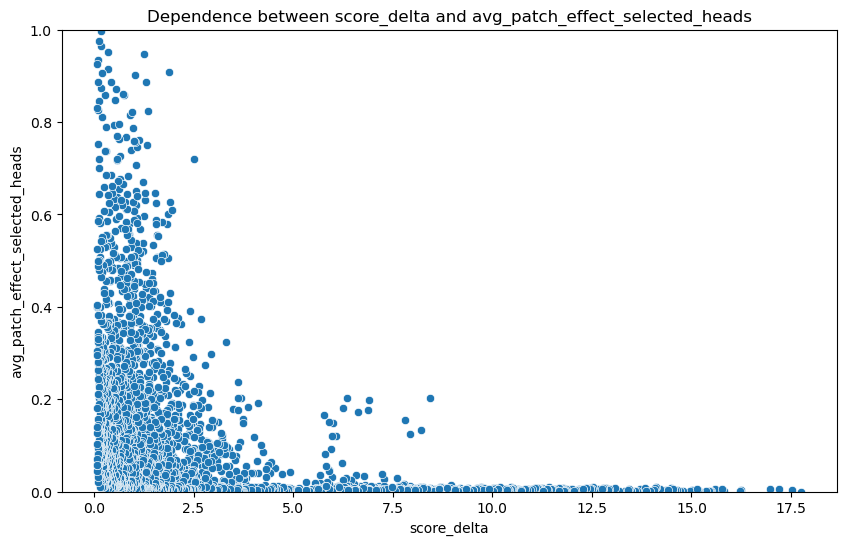

In [48]:
plot_dependence(all_data_pd, 'score_delta', 'avg_patch_effect_selected_heads')

Corellation between relevance and patching effect

In [49]:
target_property = 'relevance'

In [50]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

np.float64(0.1844279120272692)

In [51]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

np.float64(0.16178853539448604)

In [52]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

np.float64(0.6754629373888965)

In [53]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

np.float64(0.6190447030538196)

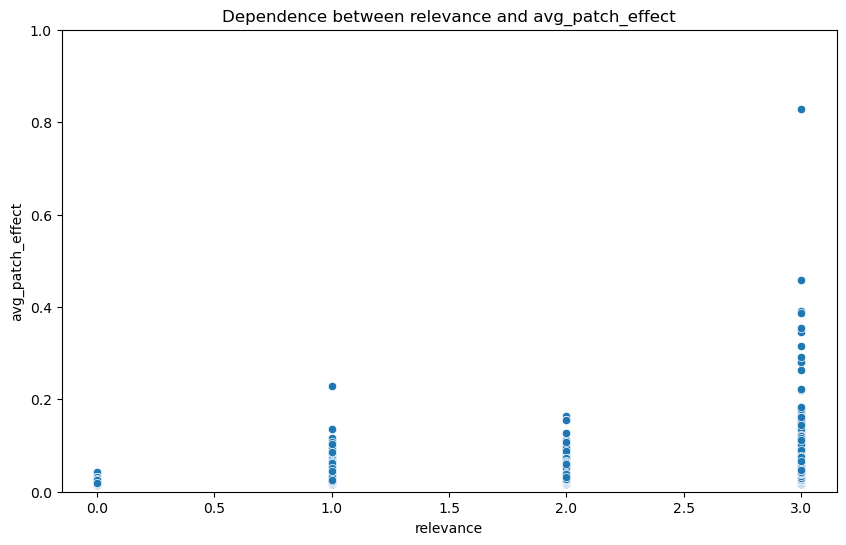

In [54]:
plot_dependence(all_data_pd, 'relevance', 'avg_patch_effect')

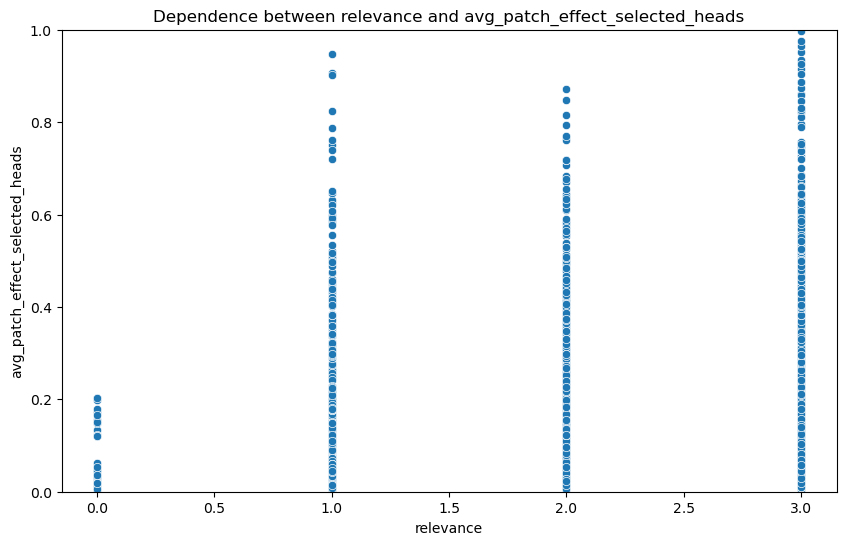

In [55]:
plot_dependence(all_data_pd, 'relevance', 'avg_patch_effect_selected_heads')

Document length

In [56]:
target_property = 'tokenized_doc_length'

In [57]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

np.float64(0.002217904562986099)

In [58]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

np.float64(0.012072923434463896)

In [59]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

np.float64(0.13051433276749733)

In [60]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

np.float64(0.1915457724266515)

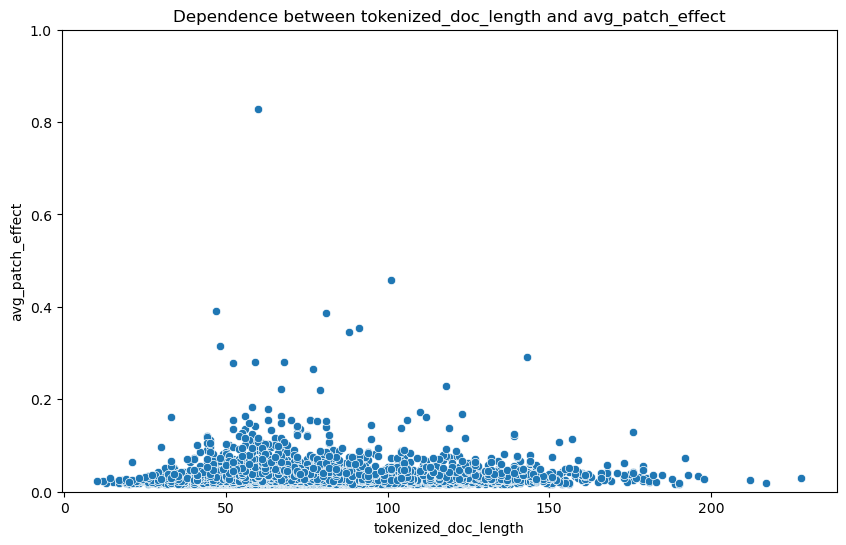

In [61]:
plot_dependence(all_data_pd, 'tokenized_doc_length', 'avg_patch_effect')

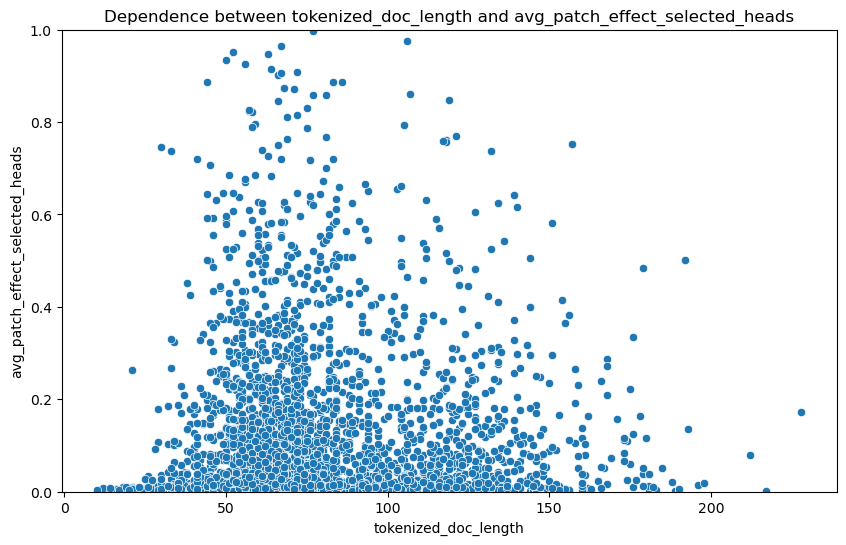

In [62]:
plot_dependence(all_data_pd, 'tokenized_doc_length', 'avg_patch_effect_selected_heads')

Query length

In [33]:
target_property = 'tokenized_query_length'

In [34]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.004085202334696974

In [35]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

0.0033162878138739372

In [36]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.08223065057675322

In [37]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

0.0770333840367118

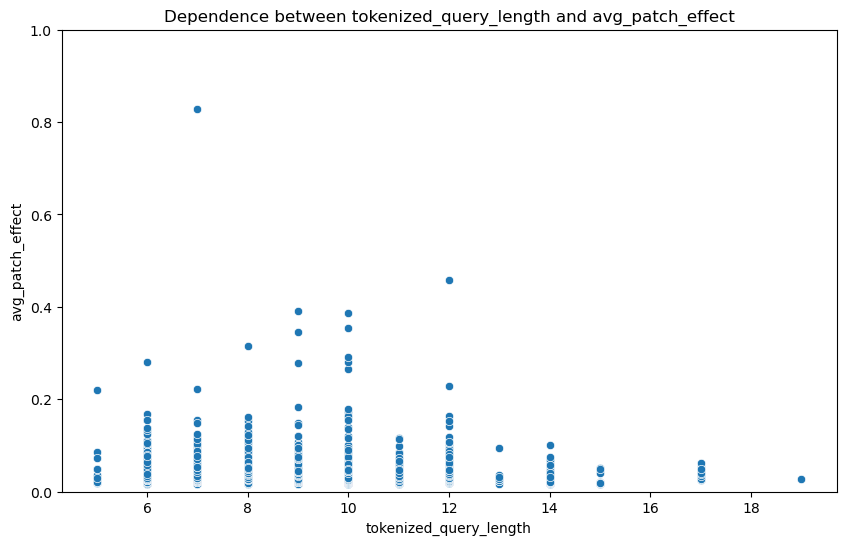

In [63]:
plot_dependence(all_data_pd, 'tokenized_query_length', 'avg_patch_effect')

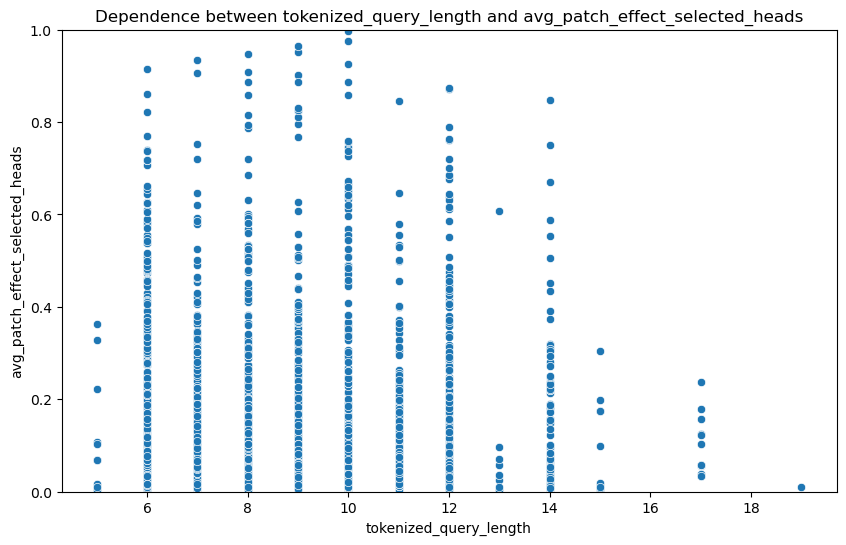

In [64]:
plot_dependence(all_data_pd, 'tokenized_query_length', 'avg_patch_effect_selected_heads')

Original score

In [38]:
target_property = 'original_score'

In [39]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.16208419498995616

In [40]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

0.1504951508721953

In [41]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.6886007673029705

In [42]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

0.6288700622483249

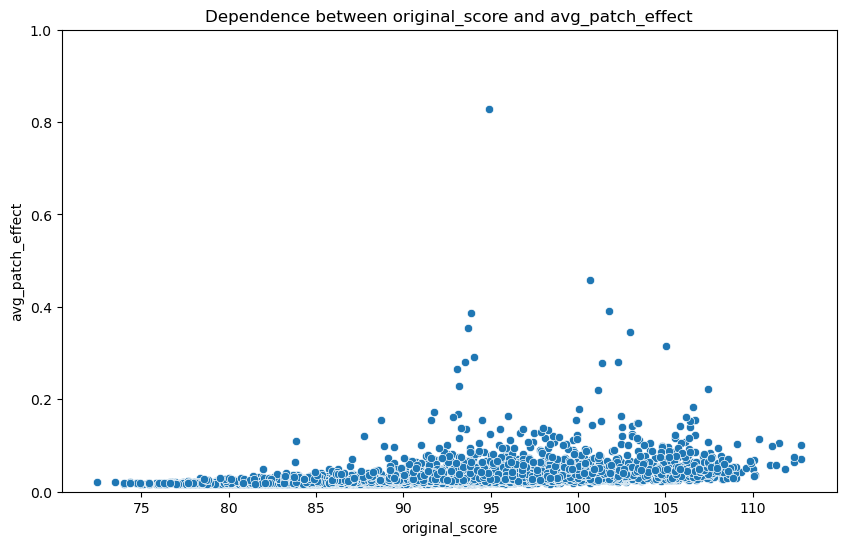

In [65]:
plot_dependence(all_data_pd, 'original_score', 'avg_patch_effect')

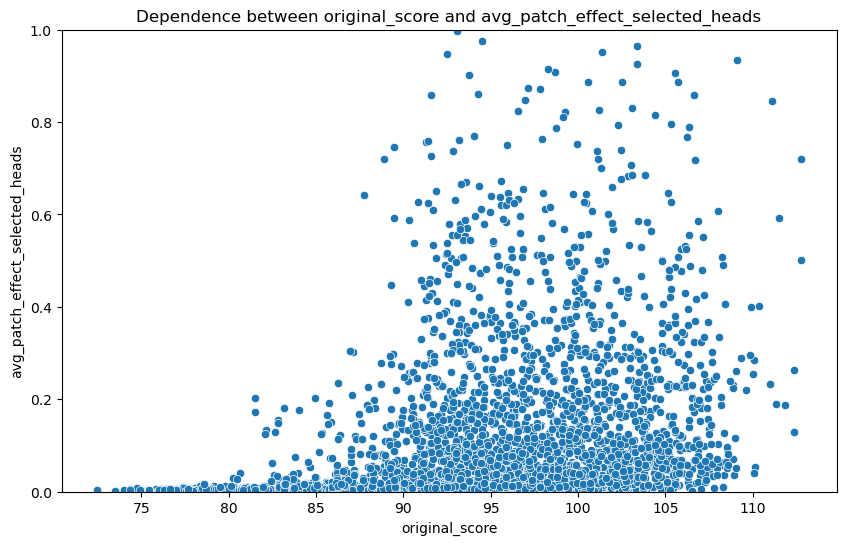

In [66]:
plot_dependence(all_data_pd, 'original_score', 'avg_patch_effect_selected_heads')

Perturbed score

In [67]:
target_property = 'perturbed_score'

In [68]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

np.float64(0.11149286659696551)

In [69]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

np.float64(0.10984425593788812)

In [70]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

np.float64(0.42057438891718685)

In [71]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

np.float64(0.38684730995805844)

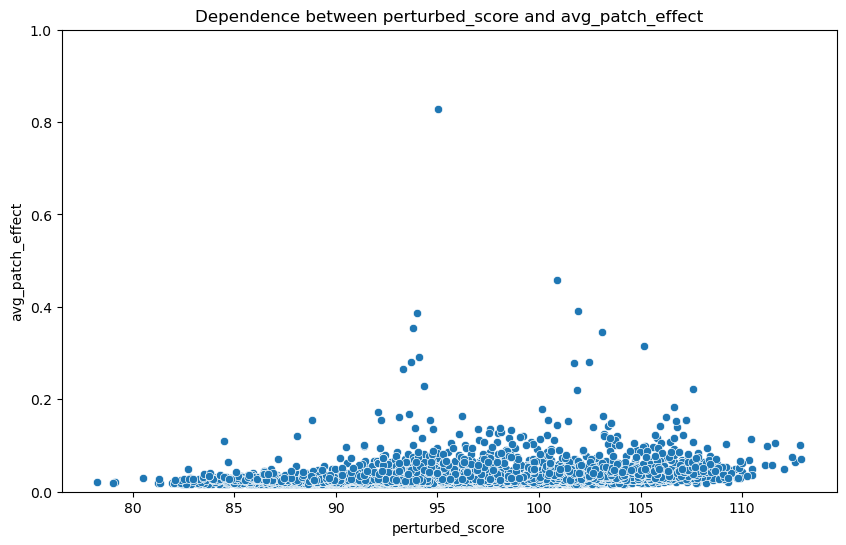

In [72]:
plot_dependence(all_data_pd, 'perturbed_score', 'avg_patch_effect')

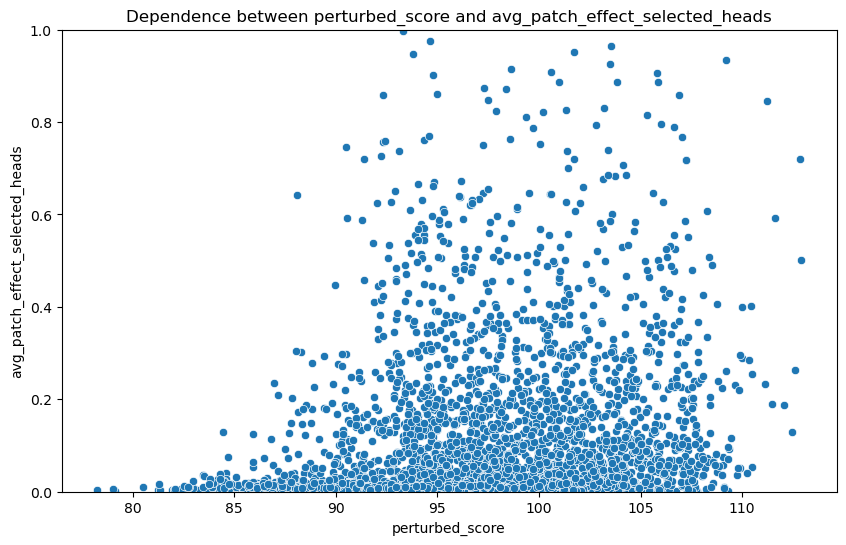

In [73]:
plot_dependence(all_data_pd, 'perturbed_score', 'avg_patch_effect_selected_heads')

Appended term exists in the original document

In [56]:
target_property = 'injected_term_exists'

In [57]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='pearson')

0.17529643330523026

In [58]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='pearson')

0.19519730129681384

In [59]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman')

0.6568338975945964

In [60]:
all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')

0.7785406762584312

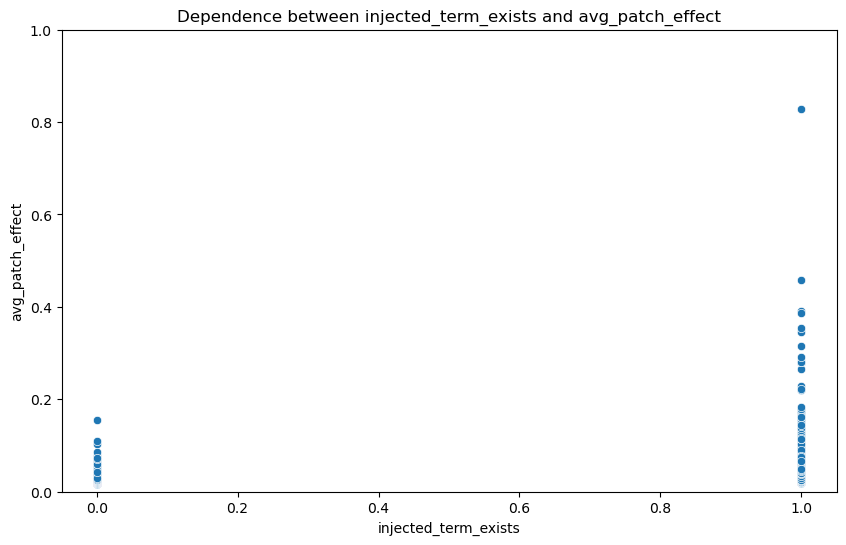

In [74]:
plot_dependence(all_data_pd, 'injected_term_exists', 'avg_patch_effect')

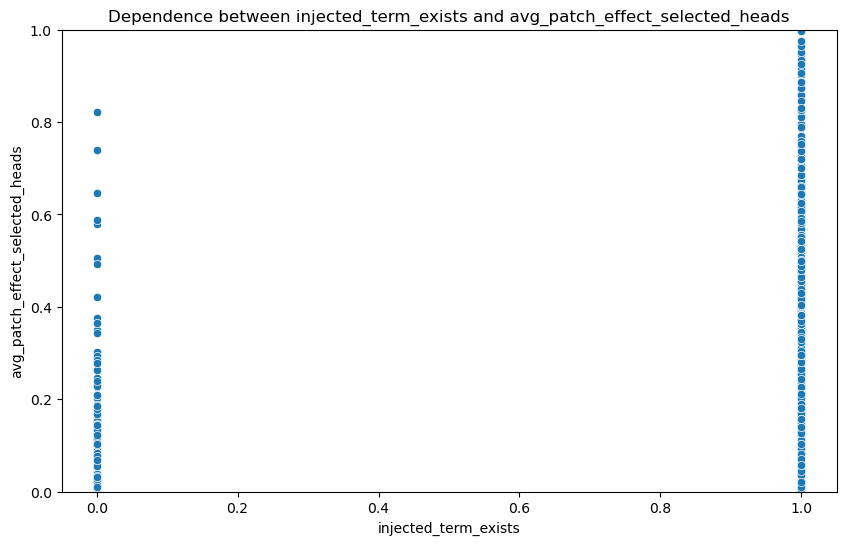

In [76]:
plot_dependence(all_data_pd, 'injected_term_exists', 'avg_patch_effect_selected_heads')

Let's combine all these results into a single pandas dataframe

In [19]:
target_properties = ['score_delta', 'relevance', 'tokenized_doc_length', 'tokenized_query_length', 'original_score', 'perturbed_score', 'injected_term_exists']
correlation_data = [{'target property': target_property, 
                     'average absolute patching effect': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect'], method='spearman'),
                     'average absolute patching effect (duplicate token heads)': all_data_pd[target_property].corr(all_data_pd['avg_patch_effect_selected_heads'], method='spearman')} for target_property in target_properties]

In [21]:
pd.DataFrame(correlation_data)

,target property,average absolute patching effect,average absolute patching effect (duplicate token heads)
0,score_delta,-0.838194,-0.730418
1,relevance,0.675463,0.619045
2,tokenized_doc_length,0.131061,0.192095
3,tokenized_query_length,0.082556,0.077183
4,original_score,0.688367,0.628460
5,perturbed_score,0.420362,0.386432
6,injected_term_exists,0.656834,0.778541


Let's try to multiply patching effect and score difference and sort them so that we could get queries and document with both high patching effect and score difference

In [ ]:
all_data_pd['patched_effect_score_diff_mult'] = all_data_pd['score_delta'] * all_data_pd['avg_patch_effect']

In [64]:
all_data_pd.sort_values(by='patched_effect_score_diff_mult', ascending=False)[['query', 'text', 'perturbed_text', 'score_delta', 'avg_patch_effect', 'patched_effect_score_diff_mult']]

,query,text,perturbed_text,score_delta,avg_patch_effect,patched_effect_score_diff_mult
3627,definition of a sigmet,The header of the SIGMET message contains the ...,The header of the SIGMET message contains the ...,0.389397,3.089701,1.203119
3385,definition of a sigmet,When significant flight/weather events are obs...,When significant flight/weather events are obs...,0.839706,1.225981,1.029464
3358,exons definition biology,After an RNA molecule is transcribed from a eu...,After an RNA molecule is transcribed from a eu...,0.899307,1.140078,1.025280
3,what is theraderm used for,": to add moisture to (something, such as a per...",": to add moisture to (something, such as a per...",16.979218,0.022695,0.385336
3928,what is a active margin,An active continental margin refers to the sub...,An active continental margin refers to the sub...,0.120155,2.732069,0.328273
...,...,...,...,...,...,...
3992,how is the weather in jamaica,"Regardless of when you visit, the tropical cli...","Regardless of when you visit, the tropical cli...",0.078117,0.051875,0.004052
3984,how long is life cycle of flea,How long is the life span of a flea? 30-90 Day...,How long is the life span of a flea? 30-90 Day...,0.086098,0.043562,0.003751
3993,what type of tissue are bronchioles,Lesson Summary. Simple cuboidal epithelium is ...,Lesson Summary. Simple cuboidal epithelium is ...,0.075684,0.047784,0.003616
3981,what type of tissue are bronchioles,Bronchioles are the terminal segments of the c...,Bronchioles are the terminal segments of the c...,0.088753,0.040374,0.003583


In [68]:
all_data_pd['patched_effect_score_diff_harmonic_mean'] = 2 / (1/all_data_pd['score_delta'] + 1/all_data_pd['avg_patch_effect'])

In [82]:
sorted_harmonic_mean = all_data_pd.sort_values(by='patched_effect_score_diff_harmonic_mean', ascending=False)[['query', 'text', 'perturbed_text', 'injected_term', 'score_delta', 'injected_term_exists', 'avg_patch_effect', 'patched_effect_score_diff_harmonic_mean']].index.values

<Axes: >

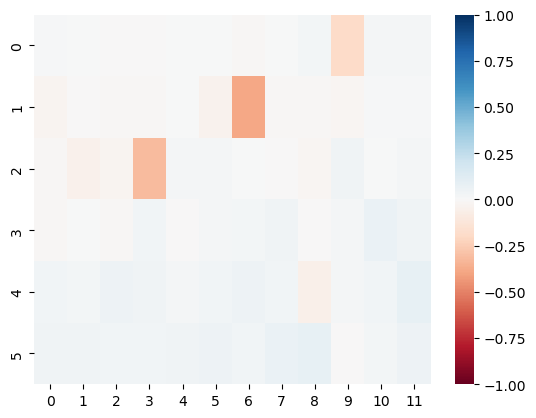

In [86]:
sns.heatmap(
        np.mean(data[sorted_harmonic_mean[:1000]], axis=0),
        vmin=-1,
        vmax=1,
        cmap='RdBu',)

In [76]:
data[]

array([[[ 2.70723854e-03,  4.69205342e-03,  2.48297793e-03, ...,
          6.53186089e-06,  5.35830297e-03,  1.69654191e-03],
        [ 9.28917713e-03,  9.85962618e-03, -1.52105268e-03, ...,
          8.46616272e-03,  2.76210625e-03, -1.02550210e-03],
        [ 5.77372918e-03, -3.53722018e-03, -2.88882433e-03, ...,
         -3.14617949e-03,  6.69254456e-03,  2.18556053e-03],
        [ 4.39289398e-03,  9.48861649e-04,  8.12955387e-03, ...,
          5.48676289e-05,  2.36035325e-02,  7.54830539e-02],
        [ 8.02012309e-02,  7.10831881e-02,  6.08869568e-02, ...,
          1.10407606e-01,  8.60246085e-03,  7.22859229e-04],
        [ 4.88282703e-02,  7.55518535e-03,  1.96652557e-03, ...,
         -6.63593505e-03,  1.42150708e-02,  2.30182763e-02]],

       [[ 1.70010945e-03, -1.22443118e-04,  2.11016182e-03, ...,
          2.96065700e-03, -5.53108146e-03,  7.99403817e-04],
        [-5.02589345e-03,  1.94719795e-03, -9.67212545e-04, ...,
         -4.40134574e-03,  8.95420380e-04, -9.28013